# Lesson 33: Review of exercise 4

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This lesson was generated from a Jupyter notebook.  You can download the notebook [here](l33_exercise_4.ipynb).*

<br /><br />

In [1]:
import tqdm

import numpy as np
import scipy.integrate
import pandas as pd

import numba

import altair as alt

import bootcamp_utils

## Exercise 4.0: Complete practice

If you have not already, complete the exercises from [lesson 29](l29_practice_with_numpy.html) and [lessons 31 and 32](l31_32_practice_with_hackerstats.html).

<br />

## Exercise 4.1: Data collapse

Rob Phillips wrote a review paper a couple of years ago that I enjoyed entitled ["Napoleon is in Equilibrium."](https://dx.doi.org/10.1146%2Fannurev-conmatphys-031214-014558). In the paper, he demonstrated that when you plot data in a certain way, they demonstrate **data collapse**. The idea here is that if you choose the right thing to plot on the $x$ and $y$ axes, data from a variety of sources collapse onto a single universal curve. In this exercise, you will hone your NumPy and Matplotlib skills in making plots exhibiting data collapse along the way. 

This analysis comes from Rob's paper, and the data come from [Daber, Sochor, and Lewis, *J. Mol. Biol.*, **409**, 76–87, 2011](https://doi.org/10.1016/j.jmb.2011.03.057). The authors were studying how different mutants of the lac repressor affect gene expression. They hooked the lac promoter up to a fluorescent protein reporter. They then made a mutant with no lac repressor to get a measurement of the gene expression level (quantified by the fluorescent signal) in the absence of repressor. Then then looked at how the presence of a repressor served to decrease the expression level of the lac gene. The ratio of the repressed fluorescence to the totally unrepressed fluorescence is the **fold change** in repression. They can block repression by adding IPTG, which binds the lac repressor, rendering it ineffective at repressing gene expression (so IPTG is called an "inducer," since it turns on gene expression). So, for a given experiment, the authors measured fold change as a function of IPTG concentration. They measured the fold change for wild type, plus two mutants, Q18M and Q18A.

We will not derive it here (it comes from a generalization of the [Monod-Wyman-Changeux model](https://en.wikipedia.org/wiki/Monod-Wyman-Changeux_model)), but the theoretical expression for the fold change as a function of IPTG concentration, $c$, is

\begin{align}
\text{fold change} = \left[1 + \frac{\frac{R}{K}\left(1 + c/K_\mathrm{d}^\mathrm{A}\right)^2}{\left(1 + c/K_\mathrm{d}^\mathrm{A}\right)^2 + K_\mathrm{switch}\left(1 + c/K_\mathrm{d}^\mathrm{I}\right)^2}\right]^{-1}.
\end{align}

The parameters are:

|Parameter|Description|Value|Units|
|:--:|:--:|:--:|:--:|
|$K_\mathrm{d}^\mathrm{A}$|dissoc. const. for active repressor binding IPTG|0.017|mM$^{-1}$|
|$K_\mathrm{d}^\mathrm{I}$|dissoc. const. for inactive repressor binding IPTG|0.002|mM$^{-1}$|
|$K_\mathrm{switch}$|equil. const. for switching active/inactive|5.8|---|
|$K$|dissoc. const. for active repressor binding operator|?|mM$^{-1}$|
|$R$|number of repressors in cell|?|---|

The values of $K_\mathrm{d}^\mathrm{A}$, $K_\mathrm{d}^\mathrm{I}$, and $K_\mathrm{switch}$ were measured in the Daber, Sochor, and Lewis paper, and, as I mentioned before, are the same for all mutants. You can see in the expression for the fold change that $R$ and $K$ always appear as a ratio, $R/K$, so we can only determine this *ratio*, $R/K$, for each mutant. They are, for the respective mutants:

|Mutant|$R/K$|
|:--:|:--:|
|WT|141.5 mM$^{-1}$|
|Q18A|16.56 mM$^{-1}$|
|Q18M|1332 mM$^{-1}$|

Now let's get started with the analysis.

**a)** Load in the three data sets. They are in the files `~/git/data/wt_lac.csv`, `~/git/data/q18m_lac.csv`, and `~/git/data/q18a_lac.csv`. You should put them in a single `DataFrame` with an added column for genotype. This can be accomplished, for example, with `pd.concat()`.

**b)** Make a plot of fold change vs. IPTG concentration for each of the three mutants. Think: should any of the axes have a logarithmic scale?

**c)** Write a function with the signature `fold_change(c, RK, KdA=0.017, KdI=0.002, Kswitch=5.8)` to compute the theoretical fold change. It should allow `c`, the concentration of IPTG, to be passed in as a NumPy array or scalar, and `RK`, the $R/K$ ratio, must be a scalar. Remember, with NumPy arrays, you don't have to write **`for`** loops to do operations to each element of the array.

**d)** You will now plot a smooth curve showing the theoretical fold change for each mutant. 
>1. Make an array of closely spaced points for the IPTG concentration. *Hint*: The function `np.logspace()` will be useful.
2. Compute the theoretical fold change based on the given parameters using the function you wrote in part (c).
3. Plot the smooth curves on the same plot with the data. Don't forget to properly annotate your plot with axis labels and a legend.

**e)** If we look at the functional form of the fold change and at the parameters we are given, we see that only $R/K$ varies from mutant to mutant. I told you this *a priori*, but we didn't really know it. Daber, Sochol, and Lewis assumed that the binding to IPTG would be unaltered and the binding to DNA would be altered based on the position of the mutation in the lac repressor protein. Now, *if* this is true, then $R/K$ should be the only thing that varies. We can check this by seeing if the data collapse onto a single curve. To see how this works, we define the **Bohr parameter**, $F(c)$, as

\begin{align}
F(c) = -\ln\left(R/K\right) - \ln\left(\frac{\left(1 + c/K_\mathrm{d}^\mathrm{A}\right)^2}{\left(1 + c/K_\mathrm{d}^\mathrm{A}\right)^2 + K_\mathrm{switch}\left(1 + c/K_\mathrm{d}^\mathrm{I}\right)^2}\right).
\end{align}

The second term in the Bohr parameter is independent of the identity of the mutant, and the first term depends entirely upon it. Then, the fold change can be written as

\begin{align}
\text{fold change} = \frac{1}{1 + \mathrm{e}^{-F(c)}}.
\end{align}

So, if we make our $x$-axis be the Bohr parameter, all data should fall on the *same* curve. Hence the term, data collapse. (The Bohr parameter gets its name (as given by Rob Phillips) because it is inspired by the work of Christian Bohr (Niels's father), who discovered similar families of curves describing binding of oxygen to hemoglobin.)

Now, we will plot the theoretical curve of fold change versus Bohr parameter. 
>1. Write a function with call signature `bohr_parameter(c, RK, KdA=0.017, KdI=0.002, Kswitch=5.8)` that computes the Bohr parameter.
2. Write a function with call signature `fold_change_bohr(bohr_parameter)` that gives the fold change as a function of the Bohr parameter. 
3. Generate values of the Bohr parameter ranging from $-6$ to $6$ in order to make a smooth plot.
4. Compute the theoretical fold change as a function of the Bohr parameter and plot it as a gray line using `plt.plot()`'s kwarg `color='gray'`.

**f)** Now, for each experimental curve:
>1. Convert the IPTG concentration to a Bohr parameter using the given parameters.
2. Plot the experimental fold change versus the Bohr parameter you just calculated. Plot the data as dots on the same plot that you made the universal gray curve, making sure to appropriately annotate your plot.

Do you see data collapse? Does it make sense only binding to the operator is changing from mutant to mutant? And importantly, the collapse demonstrates that all of the mutants are behaving according to the Monod-Wyman-Changeux model, and the mutations affect quantitative, not qualitative, changes in the behavior of the repressor.

### Exercise 4.1: solution

**a)** After checking out the files, we see that there are two comment lines, starting the `#`. We'll load in the data frames, add the genotype column, and then concatenate them to make a single data frame. Lastly, we need to change the name of the `[IPTG] (mM)` column so it plays nicely with Altair.

In [2]:
df_wt = pd.read_csv('data/wt_lac.csv', comment='#')
df_q18a = pd.read_csv('data/q18a_lac.csv', comment='#')
df_q18m = pd.read_csv('data/q18m_lac.csv', comment='#')

# Add genotype column to DataFrames
df_wt['genotype'] = 'WT'
df_q18a['genotype'] = 'Q18A'
df_q18m['genotype'] = 'Q18M'

# Concatenate into a single DataFrame
df = pd.concat([df_wt, df_q18a, df_q18m], ignore_index=False)

# Change the IPTG column to play nice with Altair
df = df.rename(columns={'[IPTG] (mM)': 'iptg (mM)'})

# Take a look
df.head()

,iptg (mM),fold change,genotype
0,0.000010,0.040697,WT
1,0.000974,0.072788,WT
2,0.002044,0.105284,WT
3,0.004049,0.199477,WT
4,0.007584,0.343024,WT


**b)** The IPTG concentration varies over five or six orders of magnitude, so we should have the IPTG (*x*) axis be on a logarithmic scale. The fold change is all within one order of magnitude, so we keep the *y*-axis on a linear scale.

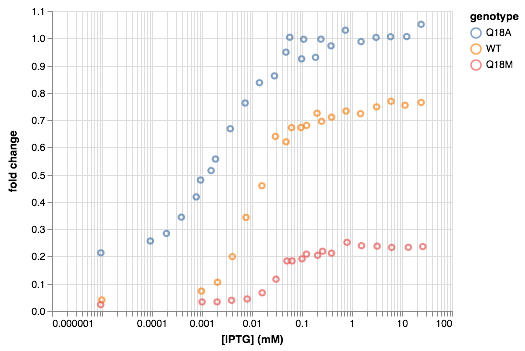

In [3]:
dots = alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('iptg (mM):Q', 
                title='[IPTG] (mM)', 
                scale=alt.Scale(type='log')),
        y='fold change:Q',
        color=alt.Color('genotype:N', sort=['Q18A', 'WT', 'Q18M'])
    )

dots

**c)** We use the convenience of NumPy's broadcasting. We can almost just type it out as if we were computing it for a single value of $c$.

In [4]:
# Fold change function
def fold_change(c, RK, KdA=0.017, KdI=0.002, Kswitch=5.8):
    """Compute theoretical fold change for MWC model."""
    # Inverse fold change
    inv_fc = 1 + (1 + c/KdA)**2 * RK / ((1 + c/KdA)**2 + Kswitch*(1 + c/KdI)**2)

    return 1 / inv_fc

**d)** First, we need to make our theoretical curves and put them in a tidy data frame. The [`pd.melt()` function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html) is really useful for this purpose. (In general `pd.melt()` is a great tool for making data frames tidy.)

In [5]:
# Theoretical concentration
c = np.logspace(-6, 2, 200)

# Make smooth curves
df_smooth = pd.DataFrame({'c': c,
                         'WT': fold_change(c, 141.5),
                         'Q18A': fold_change(c, 16.56),
                         'Q18M': fold_change(c, 1332)})

# Melt it to make it tidy
df_smooth = pd.melt(df_smooth, 
                    id_vars='c', 
                    var_name='genotype', 
                    value_name='fold change')

We can now make out plot of the fit lines. To make the curves have the same color as the data points, we need to keep the same ordering of colors as in the scatter plot we made.

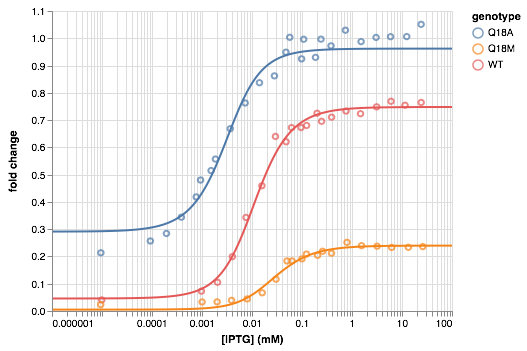

In [6]:
lines = alt.Chart(df_smooth
    ).mark_line(
        size=2
    ).encode(
        x=alt.X('c:Q',
                title='[IPTG] (mM)', 
                scale=alt.Scale(type='log')),
        y=alt.Y('fold change:Q'),
        order='c:Q',
        color=alt.Color('genotype:N',
                        legend=None,
                        sort=['Q18A', 'WT', 'Q18M'])
    )

lines + dots

**e and f)** First, we'll add the RK and Bohr parameter columns to the `DataFrame` containing the measurements.

In [7]:
def rk(x):
    """Give value of RK for a given genotype."""
    rk_vals = {'WT': 141.5,
               'Q18A': 16.56,
               'Q18M': 1332}    
    return rk_vals[x]

def bohr_parameter(c, RK, KdA=0.017, KdI=0.002, Kswitch=5.8):
    """Compute Bohr parameter based on MWC model."""
    # Big nasty argument of logarithm
    log_arg = (1 + c/KdA)**2 / ((1 + c/KdA)**2 + Kswitch*(1 + c/KdI)**2)

    return -np.log(RK) - np.log(log_arg)


df['RK'] = df['genotype'].transform(rk)
df['Bohr parameter'] = bohr_parameter(df['iptg (mM)'], df['RK'])

Next, we'll make a data frame to plot the smooth function for the fold change versus Bohr parameter.

In [8]:
bohr = np.linspace(-6, 6, 200)
fold_change_bohr = 1 / (1 + np.exp(-bohr))

df_bohr = pd.DataFrame({'Bohr parameter': bohr, 
                        'fold change': fold_change_bohr})

Our `DataFrame`s are all in place, so we can compose the plot with Altair.

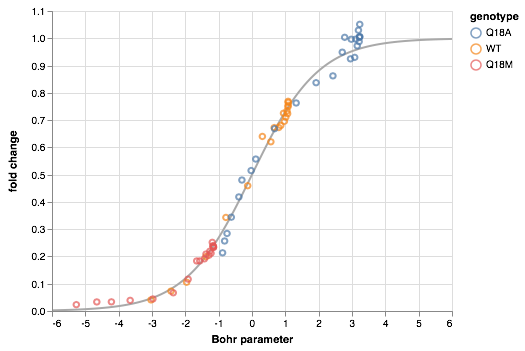

In [9]:
dots = alt.Chart(df
    ).mark_point(
    ).encode(
        x='Bohr parameter:Q',
        y='fold change:Q',
        color=alt.Color('genotype:N', sort=['Q18A', 'WT', 'Q18M'])
    )

line = alt.Chart(df_bohr
    ).mark_line(
        color='darkgray',
        size=2
    ).encode(
        x='Bohr parameter:Q',
        y='fold change:Q',
        order='Bohr parameter:Q'
    )

line + dots

When plotted this way, all data fall on the same curve, clearly demonstrating data collapse. This suggests that indeed the only thing varying between the different mutants is the parameter $R/K$, the number of repressors divided by the repressor-operator dissociation constant.

<br />

## Exercise 4.2: Solving differential equations with NumPy

In addition to handling data, NumPy allows you do to *simulations*. For this exercise, we will use Euler's method to simulate a classic model for predator-prey population dynamics, the [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka–Volterra_equations). As a warm-up example, we will simulate bacterial growth.

Bacterial growth can be modeled by the differential equation

\begin{align}
\frac{\mathrm{d}n}{\mathrm{d}t} = k n,
\end{align}

where $n$ is the number of bacteria and $k$ is the growth rate. The idea here is that the number of bacteria will grow faster the more bacteria we have, because there are more to divide. Analytically, we know the solution to this differential equation is

\begin{align}
n(t) = n_0 \mathrm{e}^{kt},
\end{align}

i.e., exponential growth. But suppose we did not know how to derive that. We could *simulate* the differential equation. We do this by discretizing time. Instead of a derivative, we have a change in $n$ over a change in time $t$.

\begin{align}
\frac{\mathrm{d}n}{\mathrm{d}t} \approx \frac{\Delta n}{\delta t} = k n.
\end{align}

Let's say we know $n$ and time zero, $n(0)$. Then $n$ at time $t = \Delta t$ is

\begin{align}
n(\Delta t) \approx n(0) + \Delta n = n(0) + k n(0).
\end{align}

More generally, we can write

\begin{align}
\frac{\mathrm{d}n}{\mathrm{d}t} = f(n),
\end{align}

and

\begin{align}
n(t+\Delta t) \approx n(t) + \Delta t\,f(n).
\end{align}

So, we can instruct Python to take our current value of $n$, and then add $\Delta t$ times $f(n)$ to get our new $n$ at a time just a bit later on, at $t + \Delta t$. We repeat this over and over again to move forward in time. Let's code that up!

In [10]:
# Specify parameter
k = 1

# Specify my little time step
delta_t = 0.01

# Make an array of time points, evenly spaced up to 10
t = np.arange(0, 10, delta_t)

# Make an array to store the number of bacteria
n = np.empty_like(t)

# Set the initial number of bacteria
n[0] = 100

# Write a for loop to keep updating n as time goes on
for i in range(1, len(t)):
    n[i] = n[i-1] + delta_t * k * n[i-1]

Ok! We just computed the time points and the number of bacteria, so we can just plot the result!

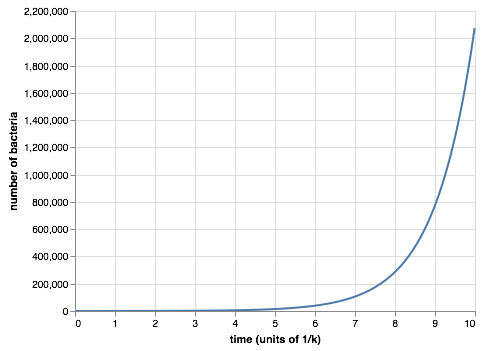

In [11]:
# Data frame for plotting
df = pd.DataFrame({'time (units of 1/k)': t,
                   'number of bacteria': n})

alt.Chart(df
    ).mark_line(
    ).encode(
        x='time (units of 1/k):Q',
        y='number of bacteria:Q',
        order='time (units of 1/k):Q'
    )

And there is the famous exponential growth!

This time stepping method is called [Euler's method](https://en.wikipedia.org/wiki/Euler_method), and what we're doing is called *numerical solution of a differential equation*.

**a)** Now it's time to simulate the Lotka-Volterra model. Since predator and prey both begin with "p," we'll call the predators foxes ($f$) and the prey rabbits ($r$). The differential equation describing the dynamics of the rabbit population is

\begin{align}
\frac{\mathrm{d}r}{\mathrm{d}t} = \alpha r - \beta f r.
\end{align}

The first term at the right hand side is exponential growth, the same you would expect for a growing bacterial colony. The second term is killing off due to predation. If $f$ is large, more rabbits get hunted down.

The differential equation describing the dynamics of the fox population is

\begin{align}
\frac{\mathrm{d}f}{\mathrm{d}t} = \delta f r - \gamma f.
\end{align}

The first term represents growth in the fox population by consumption of rabbits. The second term is the natural die-off of foxes.

Your task in this exercise is to numerically solve these two differential equations together and then plot the result. Use the following parameter values

    alpha = 1
    beta = 0.2
    delta = 0.3
    gamma = 0.8
    delta_t = 0.001
    t = np.arange(0, 60, delta_t)
    r[0] = 10
    f[0] = 1

Even though there are now two differential equations, the procedure is the same, you update each by adding $\Delta t$ times the respective derivative.

When you plot the result, does it make sense?

**b)** [Bonus]  Euler's method is probably the simplest way to solve differential equations, and is by no means the best. SciPy has an ODE solver, `scipy.integrate.odeint()` that uses the more sophisticated and robust methods for solving systems of ODEs. Read the documentation about how `scipy.integrate.odeint()` works and use it to solve the Lotka-Volterra system of ODEs.

This problem is tough; I'm not giving you directions, and you are kind of on your own to read the documentation and figure it out. It may be useful to read [this tutorial](http://be150.caltech.edu/2018/handouts/intro_to_python_for_systems_biology.html) I wrote to help students solve ODEs that come up in systems biology.

### Exercise 4.2: solution

**a)** We take the same approach as in the exponential growth example. We just have to update  *two* variables at each time step, the rabbit and fox populations.

In [12]:
# Specify parameters
alpha = 1
beta = 0.2
delta = 0.3
gamma = 0.8
delta_t = 0.001
t = np.arange(0, 60, delta_t)

# Make arrays to store rabbit and fox populations
r = np.empty_like(t)
f = np.empty_like(t)

# Set initial conditions
r[0] = 10
f[0] = 1

# Write a for loop to keep updating r and f as time goes on
for i in range(1, len(t)):
    r[i] = r[i-1] + delta_t * (alpha * r[i-1] - beta * f[i-1] * r[i-1])
    f[i] = f[i-1] + delta_t * (delta * f[i-1] * r[i-1] - gamma * f[i-1])

Ok, let's see what we got!

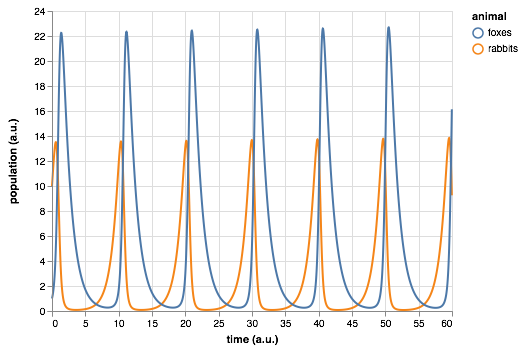

In [13]:
# Data frame for plotting (thinned for smaller file size)
df = pd.DataFrame({'time': t[::25],
                   'rabbits': r[::25],
                   'foxes': f[::25]})
df = pd.melt(df, id_vars='time', var_name='animal', value_name='population')

# Make the plot
alt.Chart(df
    ).mark_line(
    ).encode(
        x=alt.X('time:Q', title='time (a.u.)'),
        y=alt.Y('population:Q', title='population (a.u.)'),
        color='animal:N',
        order='time:Q'
    )

We get interesting behavior. When the rabbit population dies out, the foxes start to starve and their population comes down. As the fox population comes down, the rabbit population recovers because they do not have predators. When there are lots of rabbits, the foxes start eating again and their population grows. And on and on it goes!

**b)** Now, let's use `scipy.integrate.odeint()` to do the solution. We need to specify a function to compute the derivatives.

In [14]:
def dy_dt(y, t, alpha, beta, gamma, delta):
    """Right hand side of Lotka-Volterra equation; y = (rabbits, foxes)"""
    # Unpack y
    r, f = y
    
    # Compute derivatives
    dr_dt = alpha * r - beta * f * r
    df_dt = delta * r * f - gamma * f
    
    return np.array([dr_dt, df_dt])

Now we have to specify the initial conditions.

In [15]:
y0 = np.array([10, 1])

And specify the time points we want.

In [16]:
t = np.linspace(0, 60, 1000)

And then we just stuff the system into `scipy.integrate.odeint()`. We have to be sure to pass the additional arguments that `dy_dt()` takes as a tuple.

In [17]:
y = scipy.integrate.odeint(dy_dt, y0, t, args=(alpha, beta, gamma, delta))

Now we can parse the results and make plots.

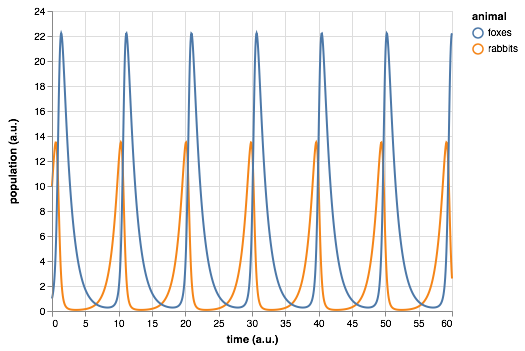

In [18]:
# Data frame for plotting (thinned for smaller file size)
df = pd.DataFrame({'time': t,
                   'rabbits': y[:,0],
                   'foxes': y[:,1]})
df = pd.melt(df, id_vars='time', var_name='animal', value_name='population')

# Make the plot
alt.Chart(df
    ).mark_line(
    ).encode(
        x=alt.X('time:Q', title='time (a.u.)'),
        y=alt.Y('population:Q', title='population (a.u.)'),
        color='animal:N',
        order='time:Q'
    )

We get the same result as with Euler's method. While we haven't experienced it here, Euler's method has serious problems with stability (try re-running it with `delta_t = 0.05` and then again with `delta_t = 0.1` and see what happens). In general, it is much better to use the highly optimized and more stable algorithms of `scipy.integrate.odeint()`.

<br />

## Exercise 4.3: Hacker stats on bee sperm data

Neonicotinoid pesticides are thought to have inadvertent effects on service-providing insects such as bees. A study of this was [featured in the New York Times](http://www.nytimes.com/2016/07/29/science/neonicotinoid-insecticide-bee-sperm.html) in 2016. The original paper is [Straub, et al.,  Proc. Royal Soc. B 283(1835): 20160506](http://dx.doi.org/10.1098/rspb.2016.0506). Straub and coworkers put their [data in the Dryad repository](http://dx.doi.org/10.5061/dryad.bs515), which means we can work with it!

(Do you see a trend here? If you want people to think deeply about your results, explore them, learn from them, further science with them, *make your data publicly available.* Strongly encourage the members of your lab to do the same.)

We will look at the weight of drones (male bees) using the data set stored in `~/git/bootcamp/data/bee_weight.csv` and the sperm quality of drone bees using the data set stored in `~/git/bootcamp/data/bee_sperm.csv`.

**a)** Load the drone weight data in as a Pandas `DataFrame`.  Note that the unit of the weight is milligrams (mg).

**b)** Plot ECDFs of the drone weight for control and also for those exposed to pesticide. Do you think there is a clear difference?

**c)** Compute the mean drone weight for control and those exposed to pesticide. Compute 95% bootstrap confidence intervals on the mean.

**d)** Repeat parts (a)-(c) for drone sperm. Use the `'Quality'` column as your measure. This is defined as the percent of sperm that are alive in a 500 µL sample.

**e)** As you have seen in your analysis in part (d), both the control and pesticide treatments have some outliers with very low sperm quality. This can tug heavily on the mean. So, get 95% bootstrap confidence intervals for the *median* sperm quality of the two treatments.

### Exercise 4.3: solution

**a)** After inspecting the data set, we see that the comments are given by `#`, and this is a standard CSV file.

In [19]:
df_weight = pd.read_csv('data/bee_weight.csv', comment='#')

**b)** To plot the ECDFs, we first compute the ECDFs.

In [20]:
df_weight['ECDF'] = (df_weight.groupby('Treatment')['Weight']
                              .transform(bootcamp_utils.ecdf_y))

We can now make a plot of the ECDFs.

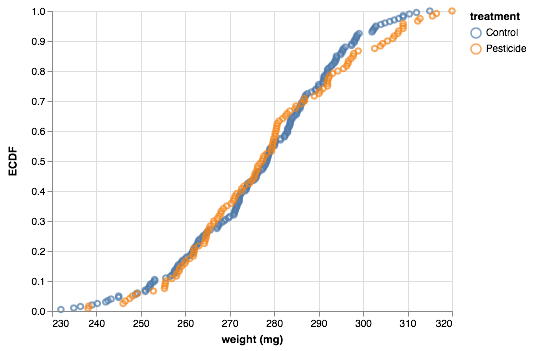

In [21]:
alt.Chart(df_weight
    ).mark_point(
    ).encode(
        x=alt.X('Weight:Q',
                title='weight (mg)', 
                scale=alt.Scale(zero=False)),
        y='ECDF:Q',
        color=alt.Color('Treatment', title='treatment')
    )

The distributions look really similar. Now, let's compute confidence intervals on the mean weight of the drones.

**c)** First, we'll get point estimates for the mean weight under control and pesticide conditions.

In [22]:
mean_control = np.mean(df_weight.loc[df_weight['Treatment']=='Control', 'Weight'])
mean_pest = np.mean(df_weight.loc[df_weight['Treatment']=='Pesticide', 'Weight'])

print('Mean control:  ', mean_control, 'mg')
print('Mean pesticide:', mean_pest, 'mg')

Mean control:   277.0563 mg
Mean pesticide: 278.27333333333326 mg


The means are really close. Let's now compute the confidence intervals. We'll use the bootstrap replicate generating function we wrote in [Lesson 31](../lessons/l31_32_practice_with_hackerstats_solution.html#Solution-1).

In [24]:
def draw_bs_reps(data, func=np.mean, size=1):
    """Draw bootstrap replicates from a data set."""
    return np.array([func(np.random.choice(data, replace=True, size=len(data))) 
                         for _ in range(size)])

# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_weight.loc[df_weight['Treatment']=='Control', 'Weight'].values,
        func=np.mean, 
        size=100000)
bs_reps_pest = draw_bs_reps(
        df_weight.loc[df_weight['Treatment']=='Pesticide', 'Weight'].values,
        func=np.mean, 
        size=100000)

Now, we can use `np.percentile()` to compute the 95% confidence interval.

In [25]:
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [274.71314625 279.41330375]
Confidence interval for pesticide: [275.055      281.52502083]


They have nearly the same confidence interval, as we would expect from the ECDFs.

**d)** We just go through the same steps as before. First, the ECDF.

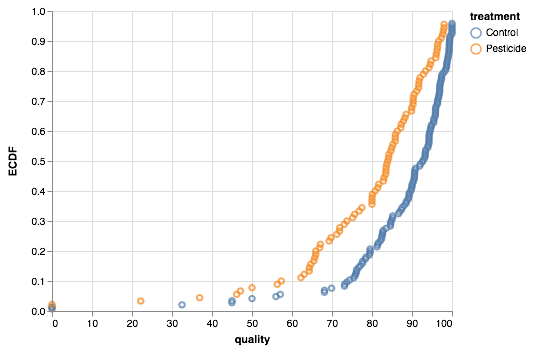

In [26]:
# Load data set
df_sperm = pd.read_csv('data/bee_sperm.csv', comment='#')

# Compute ECDF
df_sperm['ECDF'] = (df_sperm.groupby('Treatment')['Quality']
                              .transform(bootcamp_utils.ecdf_y))


alt.Chart(df_sperm
    ).mark_point(
    ).encode(
        x=alt.X('Quality:Q',
                title='quality', 
                scale=alt.Scale(zero=False)),
        y='ECDF:Q',
        color=alt.Color('Treatment', title='treatment')
    )

We have some very low quality samples from both, but it is pretty clear that on a whole the pesticide samples have much lower sperm quality. Let's compute the confidence interval on the mean. We have to be careful, though, because there are some `NaN`s in the data set, so we have to use `dropna()`.

In [27]:
# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Control', 'Quality'].dropna().values,
        func=np.mean,
        size=100000)
bs_reps_pest = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Pesticide', 'Quality'].dropna().values,
        func=np.mean, 
        size=100000)

# Compute and print confidence interval
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [84.25874107 89.53151331]
Confidence interval for pesticide: [73.99475443 82.01242602]


The confidence intervals of the mean do not overlap, further confirming that the pesticide-tested drones have lower sperm quality.

**e)** Now, let's try bootstrapping the median. This is the same procedure as before, except we just put `np.median` for our function where we have `np.median`.

In [28]:
# Draw 100,000 bootstrap reps for both.
bs_reps_control = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Control', 'Quality'].dropna().values,
        func=np.median,
        size=100000)
bs_reps_pest = draw_bs_reps(
        df_sperm.loc[df_sperm['Treatment']=='Pesticide', 'Quality'].dropna().values,
        func=np.median,
        size=100000)

# Compute and print confidence interval
conf_int_control = np.percentile(bs_reps_control, [2.5, 97.5])
conf_int_pest = np.percentile(bs_reps_pest, [2.5, 97.5])

print('Confidence interval for control:', conf_int_control)
print('Confidence interval for pesticide:', conf_int_pest)

Confidence interval for control: [89.84848485 94.2353021 ]
Confidence interval for pesticide: [80.0560062  85.84421182]


Again, we see that the confidence intervals do not overlap. The median is of course higher than the mean, since the low-quality outliers have little effect on the median.

<br />

## Exercise 4.4: Monte Carlo simulation of transcriptional pausing

In this exercise, we will put random number generation to use and do a **Monte Carlo simulation**.  The term Monte Carlo simulation is a broad term describing techniques in which a large number of random numbers are generated to (approximately) calculate properties of probability distributions.  In many cases the analytical form of these distributions is not known, so Monte Carlo methods are a great way to learn about them.

Transcription, the process by which DNA is transcribed into RNA, is key process in the central dogma of molecular biology.  RNA polymerase (RNAP) is at the heart of this process.  This amazing machine glides along the DNA template, unzipping it internally, incorporating ribonucleotides at the front, and spitting RNA out the back.  Sometimes, though, the polymerase pauses and then backtracks, pushing the RNA transcript back out the front, as shown in the figure below, taken from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009.

![Schematic of a pausing RNAP from Depken, et al., *Biophys. J.*, **96**, 2189-2193, 2009](rnap_pause.png)

To escape these backtracks, a cleavage enzyme called TFIIS cleaves the bit on RNA hanging out of the front, and the RNAP can then go about its merry way.

Researchers have long debated how these backtracks are governed. Single molecule experiments can provide some much needed insight. The groups of [Carlos Bustamante](http://bustamante.berkeley.edu), [Steve Block](https://blocklab.stanford.edu), and [Stephan Grill](http://www.biotec.tu-dresden.de/research/grill/), among others, have investigated the dynamics of RNAP in the absence of TFIIS.  They can measure many individual backtracks and get statistics about how long the backtracks last.

One hypothesis is that the backtracks simply consist of diffusive-like motion along the DNA stand.  That is to say, the polymerase can move forward or backward along the strand with equal probability once it is paused.  This is a one-dimensional **random walk**.  So, if we want to test this hypothesis, we would want to know how much time we should expect the RNAP to be in a backtrack so that we could compare to experiment.

So, we seek the probability distribution of backtrack times, $P(t_{bt})$, where $t_{bt}$ is the time spent in the backtrack.  We could solve this analytically, which requires some sophisticated mathematics.  But, because we know how to draw random numbers, we can just compute this distribution directly using Monte Carlo simulation!

We start at $x = 0$ at time $t = 0$. We "flip a coin," or choose a random number to decide whether we step left or right. We do this again and again, keeping track of how many steps we take and what the $x$ position is. As soon as $x$ becomes positive, we have existed the backtrack.  The total time for a backtrack is then $\tau n_\mathrm{steps}$, where $\tau$ is the time it takes to make a step.  Depken, et al., report that $\tau \approx 0.5$ seconds.

**a)** Write a function, `backtrack_steps()`, that computes the number of steps it takes for a random walker (i.e., polymerase) starting at position $x = 0$ to get to position $x = +1$. It should return the number of steps to take the walk.

**b)** Generate 10,000 of these backtracks in order to get enough samples out of $P(t_\mathrm{bt})$. (If you are interested in a way to really speed up this calculation, ask me about [Numba](http://numba.pydata.org).)

**c)** Plot a histogram of the backtrack times.

**d)** You saw some craziness in part (c). That is because, while most backtracks are short, some are reeeally long. So, instead, generate an ECDF of your samples and plot the ECDF with the $x$ axis on a logarithmic scale.

**e)** A probability distribution function that obeys a power law has the property

\begin{align}
P(t_\mathrm{bt}) \propto t_\mathrm{bt}^{-a}
\end{align}

in some part of the distribution, usually for large $t_\mathrm{bt}$. If this is the case, the cumulative distribution is then

\begin{align}
\mathrm{cdf}(t_\mathrm{bt}) \equiv F(t_\mathrm{bt})= \int_{-\infty}^{t_\mathrm{bt}} \mathrm{d}t_\mathrm{bt}'\,P(t_\mathrm{bt}') = 1 - \frac{c}{t_\mathrm{bt}^{a+1}}, 
\end{align}

where $c$ is some constant defined by the functional form of $P(t_\mathrm{bt})$ for small $t_\mathrm{bt}$ and the normalization condition.  If $F$ is our cumulative histogram, we can check for power law behavior by plotting the complementary cumulative distribution (CCDF), $1 - F$, versus $t_\mathrm{bt}$.  If a power law is in play, the plot will be linear on a log-log scale with a slope of $-a+1$.

Plot the complementary cumulative distribution function from your samples on a log-log plot. If it is linear, then the time to exit a backtrack is a power law.

**f)**
By doing some mathematical heavy lifting, we know that, in the limit of large $t_{bt}$,

\begin{align}
P(t_{bt}) \propto t_{bt}^{-3/2},
\end{align}

so the plot you did in part (e) should have a slope of $-1/2$ on a log-log plot. Is this what you see?

**Notes:** The theory to derive the probability distribution is involved.  See, e.g., [this](https://en.wikipedia.org/wiki/First-hitting-time_model).  However, we were able to predict that we would see a great many short backtracks, and then see some very very long backtracks because of the power law distribution of backtrack times.  We were able to do that just by doing a simple Monte Carlo simulation.  There are many problems where the theory is *really* hard, and deriving the distribution is currently impossible, or the probability distribution has such an ugly expression that we can't really work with it.  So, Monte Carlo methods are a powerful tool for generating predictions from simply-stated, but mathematically challenging, hypotheses.

Interestingly, many researchers thought (and maybe still do) there were two classes of backtracks: long and short.  There may be, but the hypothesis that the backtrack is a random walk process is commensurate with seeing both very long and very short backtracks.

### Exercise 4.4 solution

**a)** For speed, I will use Numba to compile the function. You can read more about Numba [here](http://numba.pydata.org/). For now, though, you can just ignore the `@numba.jit()` decorator on the function.

In [29]:
@numba.jit(nopython=True)
def backtrack_steps():
    """
    Compute the number of steps it takes a 1d random walker starting
    at zero to get to +1.
    """
    # Initialize position and number of steps
    x = 0
    n_steps = 0
    
    # Walk until we get to positive 1
    while x < 1:
        x += 2 * np.random.randint(0, 2) - 1
        n_steps += 1
    
    return n_steps

**b)** Now let's run it lots and lots of time. We will convert the result to time using the fact that each step takes about half a second.

When we run multiple simulations, it might be nice to have a progress bar. The `tqdm` module, which you can install on the command line using

    conda install tqdm
    
allows you to easily set up progress bars. To use it, just surround any iterator in a **`for`** loop with `tqdm.tqdm()`. For example, you could do:

    for i in tqdm.tqdm(range(10000)):
    
Unfortunately, as of June 2018, `tqdm` progress bars to not display properly in JupyterLab (only in classic notebooks). I'm sure this problem will soon be fixed, so I include it in the code below for reference.

In [30]:
# Stepping time
tau = 0.5 # seconds

# Specify number of samples
n_samples = 10000

# Array of backtrack times
t_bt = np.empty(n_samples)

# Generate the samples
for i in tqdm.tqdm_notebook(range(n_samples)):
    t_bt[i] = backtrack_steps()
    
# Convert to seconds
t_bt *= tau

**c)** Now, let's plot a histogram of our backtrack times. We'll use 100 bins. Because of the max rows limitations of Altair, we will compute the histrogram with Numpy and plot it directly.

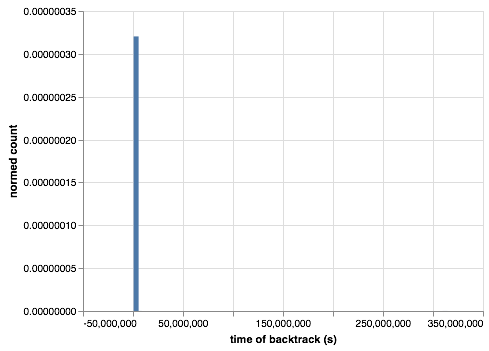

In [31]:
# Compute histograms
hist, bins = np.histogram(t_bt, bins=100, normed=True)
bins = np.diff(bins) + bins[:-1]

# Make a DataFrame with the histogram
df = pd.DataFrame({'time of backtrack (s)': bins,
                   'normed count': hist})

alt.Chart(df
    ).mark_bar(
    ).encode(
        x='time of backtrack (s):Q',
        y='normed count:Q'
    ).configure_bar(binSpacing=0)

**d)** Yeesh! Good suggestion, JB, let's plot the ECDF.

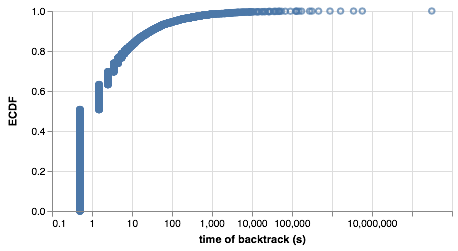

In [32]:
# Allow many points on the plot
alt.data_transformers.enable('default', max_rows=None)

# Make DataFrame of results for plotting
df = pd.DataFrame({'time of backtrack (s)': t_bt})
df['ECDF'] = df['time of backtrack (s)'].transform(bootcamp_utils.ecdf_y)

alt.Chart(df,
        height=200
    ).mark_point(
    ).encode(
        x=alt.X('time of backtrack (s):Q', scale=alt.Scale(type='log')),
        y='ECDF:Q'
    )

This makes more sense. We see that half of all backtracks end immediately, with the first step being rightward. It is impossible to leave a backtrack in an even number of steps, so there are no two-step escapes. Then, we get a lot of 3-step escapes, and so on. But this goes more and more slowly. Yes, 80% of backtracks only last 10 seconds, but there are still many extraordinarily long backtracks. These are the fundamental predictions of our hypothesis. Of course $10^7$ seconds is 115 days, which is obviously much longer than a backtrack could physically last.

**e, f)** Now, let's plot the CCDF along with a theoretical power law line.

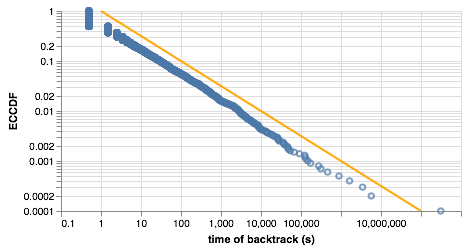

In [33]:
df['ECCDF'] = 1 - df['ECDF'] + 1/len(df)

# Theroetical line
df_line = pd.DataFrame({'x': [1, 1e8], 'y': [1, 1e-4]})

dots = alt.Chart(df,
        height=200
    ).mark_point(
    ).encode(
        x=alt.X('time of backtrack (s):Q', scale=alt.Scale(type='log')),
        y=alt.Y('ECCDF:Q', scale=alt.Scale(type='log')),
    )

line = alt.Chart(df_line,
        height=200
    ).mark_line(
        color='orange',
        size=2
    ).encode(
        x=alt.X('x:Q',
                title='time of backtrack (s)',
                scale=alt.Scale(type='log')),
        y=alt.Y('y:Q',
                title='ECCDF',
                scale=alt.Scale(type='log'))
    )

line + dots

Indeed, we see that the slope we got from Monte Carlo simulation matches what the theory predicts.